# <font color='#30a54f'>**mantis**</font>  <font color='black'>**geophysics**</font>
An Edinburgh University spinout - contact: contact@mantis-geophysics.com
### Author: G. Papageorgiou
AVO and reflection coefficients - In this notebook we showcase the anisotropic, viscoelastic reflection coefficient implementation in the mantis codebase.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import mantis_core.rock_physics as manRP
import mantis_core.rock_physics.fluid as manFL
import mantis_core.interface as manIT
import mantis_core.utilities as manUT

import mantis_core._literature as manLIT
from mantis_core.rock_physics.fluid_presets import presets as manPResets
import numpy as np
plt.style.use("plotting.mantis_plotting")


# Isotropic example: Wang geophysics 1999

We load pre-sets corresponding to literature examples and we showcase the isotropic implementation of the reflection coefficient. This particular example is from Wang 1999. The corresponding plots from the paper are shown below

In [3]:
from avo_backend.run_examples import plotting, generate_data, init_plot, close_plot

resolution: int = 128
s0 = np.linspace(0.0, 0.25, resolution)
s1 = np.linspace(0.0, 0.15, resolution)
paper = "Wang, geophysics-1999"
pairs = (
    ("shale", "sand"),
    ("shale", "limestone"),
    ("anhydrite", "sand"),
    ("anhydrite", "limestone"),
)
data = {
    f"{pair[0]}-{pair[1]}": (
        generate_data(paper=paper, pairs=pair, s_axis=s0)
        if pair[0] != "anhydrite"
        else generate_data(paper=paper, pairs=pair, s_axis=s1)
    )
    for pair in pairs
}

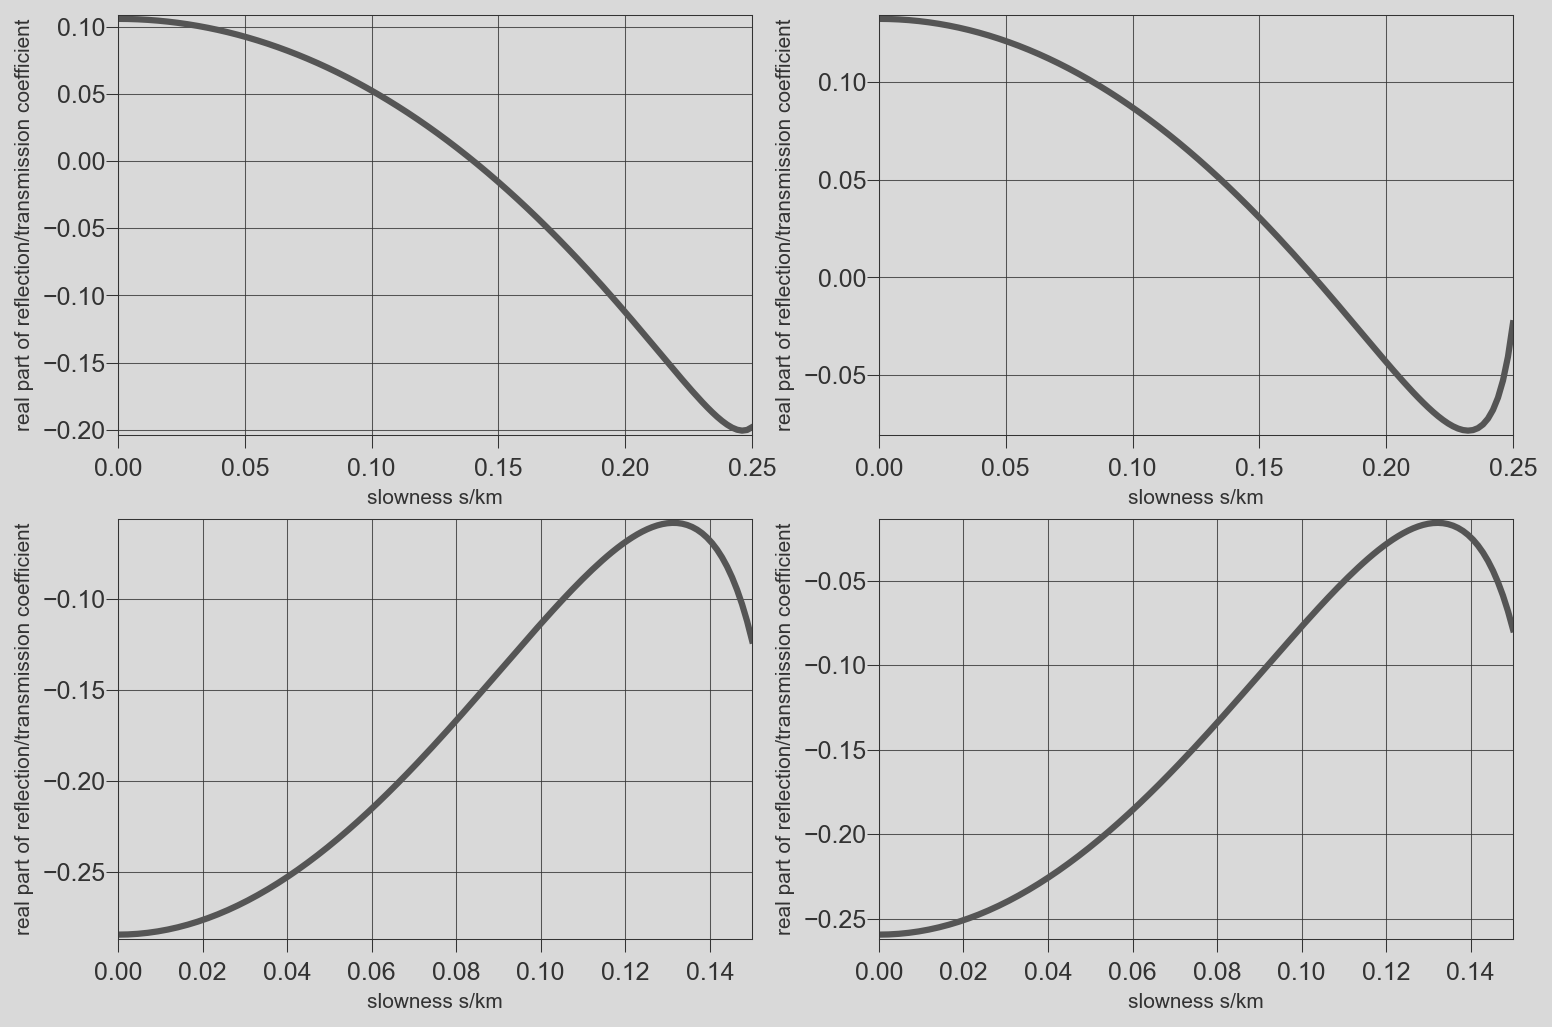

In [5]:
fig, ax = init_plot(2, 2, title="Wang, geophysics-1999")

ax[0, 0].plot(s0, data["shale-sand"][:, 0, 0, 0].T)
ax[0, 1].plot(s0, data["shale-limestone"][:, 0, 0, 0].T)
ax[1, 0].plot(s1, data["anhydrite-sand"][:, 0, 0, 0].T)
ax[1, 1].plot(s1, data["anhydrite-limestone"][:, 0, 0, 0].T)
close_plot(fig)

<img src="./avo_backend/figures/Screenshot%202024-02-22%20at%2023.22.16.png">

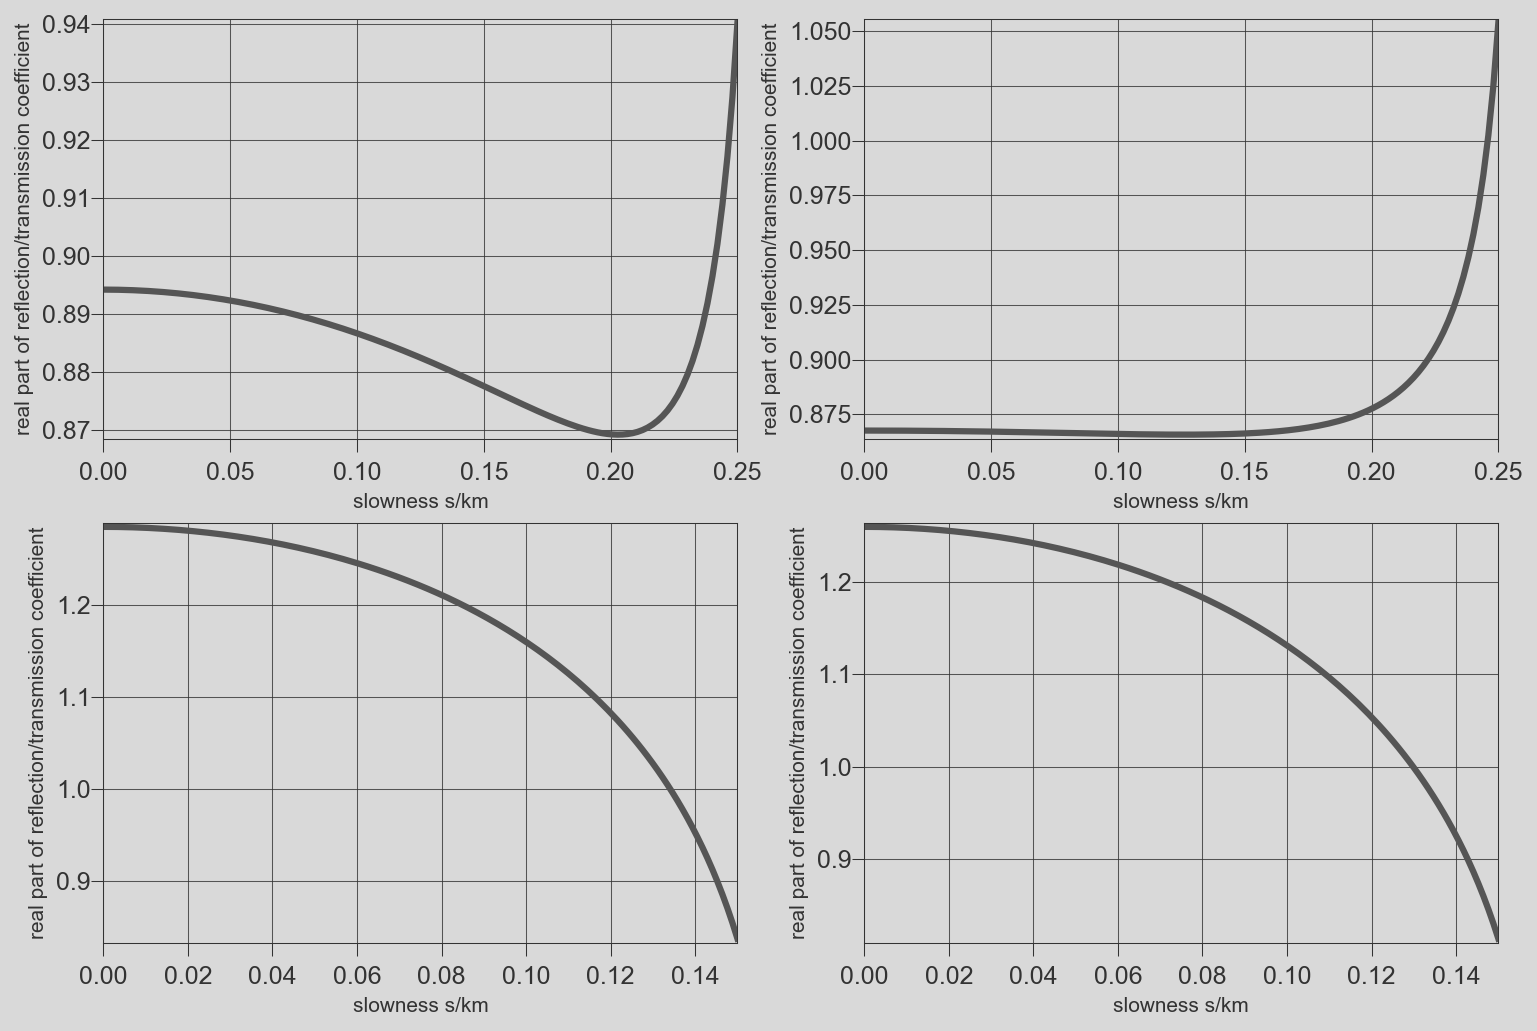

In [6]:
fig, ax = init_plot(2, 2, title="Wang, geophysics-1999")

ax[0, 0].plot(s0, data["shale-sand"][:, 1, 0, 0].T)
ax[0, 1].plot(s0, data["shale-limestone"][:, 1, 0, 0].T)
ax[1, 0].plot(s1, data["anhydrite-sand"][:, 1, 0, 0].T)
ax[1, 1].plot(s1, data["anhydrite-limestone"][:, 1, 0, 0].T)
close_plot(fig)

<img src="./avo_backend/figures/Screenshot%202024-02-22%20at%2023.22.23.png">


# Anisotropic example: Jin & Stovas 2019

In [5]:
paper = "Jin & Stovas, geophysics-2019"
pairs = (("medium-1", "medium-2"), ("medium-3", "medium-4"))
s0 = np.linspace(0.0, 0.35, resolution)

azimuthal_angles = (0.0, np.pi / 6.0, np.pi / 2.0, 2.0 * np.pi / 3.0)
labels = ["φ = 0", "φ = π/6", "φ = π/2", "φ = 2π/3"]
labels2 = ["P-P", "P-S", "P-T"]

# Generic example

A generic example with a user-defined model is also showcased.

In [11]:
import mantis_core.utilities as manU
top_properties = {"Vp": 3.0, "Vs": 1.5, "Rho": 2.4}
bot_properties = {"Vp": 3.3, "Vs": 1.7, "Rho": 2.6}

layer1 = manIT.SchoenbergProtazio(
    Cij=manUT.VtoCij(**top_properties),
    density=top_properties["Rho"],
)

layer2 = manIT.SchoenbergProtazio(
    Cij=manUT.VtoCij(**bot_properties),
    density=bot_properties["Rho"],
)

layer2VTI = manIT.SchoenbergProtazio(
    Cij=manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=.1),
    density=bot_properties["Rho"],
)

layer2HTI = manIT.SchoenbergProtazio(
    Cij=manUT.interchange_y_and_z(
        manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=0.1)
    ),
    density=bot_properties["Rho"],
)

layerrotated2HTI = manIT.SchoenbergProtazio(
    Cij=manUT.azimuthal_rotation(manUT.interchange_y_and_z(
        manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=0.1)
    ), theta = 90),
    density=bot_properties["Rho"],
)


/var/folders/sn/s_st53_16dl9zzjkw462jzlc0000gn/T/ipykernel_60491/2944387909.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  reflectivities[key][i]  = rt(horizontal_slowness=[0.01, s])[0][0,0]


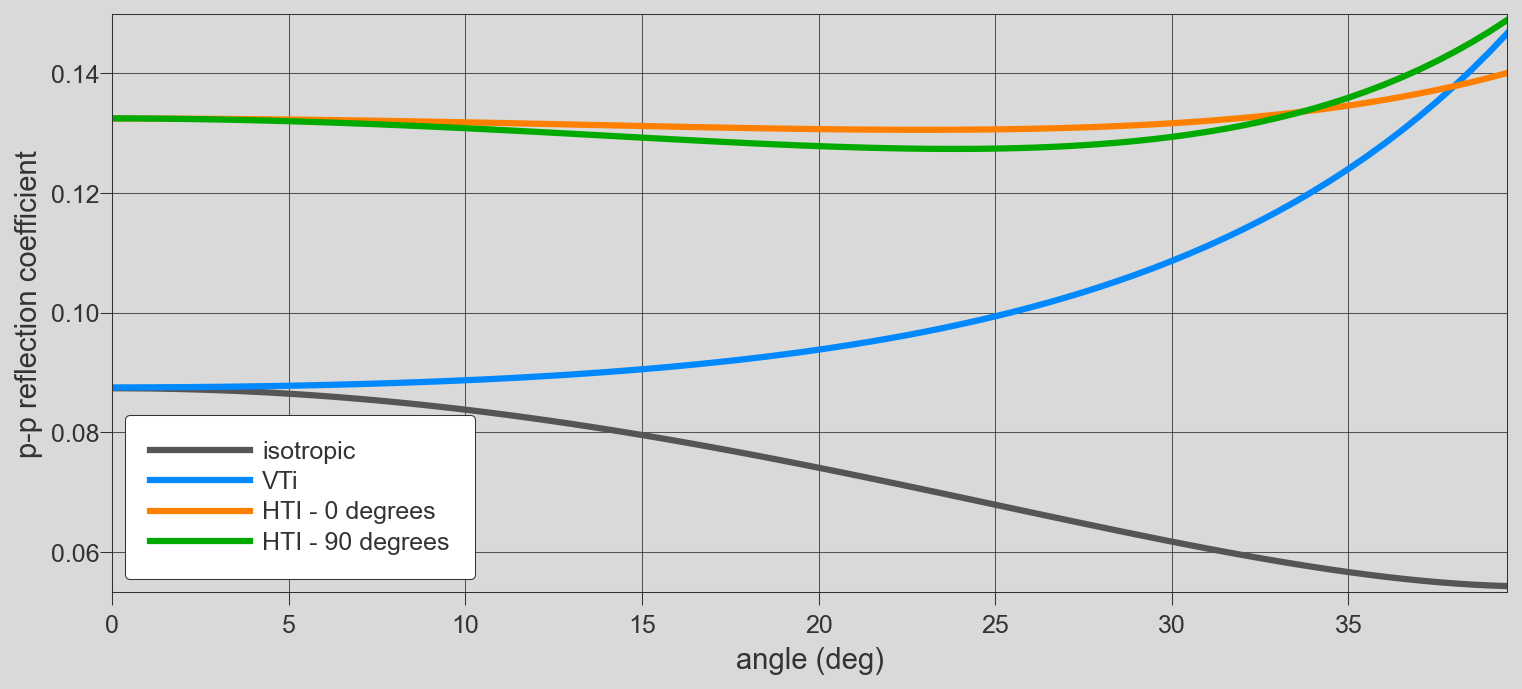

In [14]:
angles = np.arange(0.,40, 0.5)
rads = np.deg2rad(angles)
slownesses = [manUT.incidence_angle_to_slowness(incidence_angle=r, Vp=top_properties["Vp"]) for r in rads]

reflectivities = {}
labels = {"Isotropic": layer2, "VTI": layer2VTI, "HTI - 0 degrees":layer2HTI, "HTI - 90 degrees": layerrotated2HTI}

for key, val in labels.items():
    reflectivities[key] = np.empty(len(angles))
    rt = manIT.ReflectionTransmissionMatrix.sp_init(spUp=layer1, spDown=val)
    for i, s in enumerate(slownesses):
        reflectivities[key][i]  = rt(horizontal_slowness=[0.01, s])[0][0,0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(angles, reflectivities["Isotropic"], label="isotropic")
ax.plot(angles, reflectivities["VTI"], label="VTi")
ax.plot(angles, reflectivities["HTI - 0 degrees"], label="HTI - 0 degrees")
ax.plot(angles, reflectivities["HTI - 90 degrees"], label = "HTI - 90 degrees")
ax.set_xlabel("angle (deg)")
ax.set_ylabel("p-p reflection coefficient")
ax.legend()

In [16]:
rt = manIT.ReflectionTransmissionMatrix.sp_init(spUp=layer1, spDown=layer2)
reflection, transmission = rt(horizontal_slowness=[0.2, 0.0])
with np.printoptions(precision=2, suppress=True):
    print(f"reflection matrix:\n{reflection} \ntransmission matrix:\n{transmission}")

reflection matrix:
[[ 0.06-0.j -0.05-0.j  0.  +0.j]
 [-0.08-0.j -0.05-0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j -0.1 -0.j]] 
transmission matrix:
[[ 0.94-0.j  0.04-0.j  0.  +0.j]
 [-0.07-0.j  0.9 -0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.92-0.j]]
